In [223]:
dcr = dcrs[1]
rel_matrices = {}
ind = pd.Index(sorted(dcr['events']),dtype=str)
edge_weights = pd.DataFrame(0,columns=ind,index=ind,dtype=int)
for rel in ['conditionsFor', 'responseTo', 'includesTo', 'excludesTo']:#, 'milestonesFor',]:
    rel_matrix = pd.DataFrame(0,columns=ind,index=ind,dtype=int)
    for e in dcr['events']:
        for e_prime in dcr['events']:
            if e in dcr[rel] and e_prime in dcr[rel][e]:
                rel_matrix.at[e,e_prime] = 1
    edge_weights = edge_weights.add(rel_matrix,fill_value=0)
    rel_matrices[rel] = rel_matrix
rel_matrices['all'] = edge_weights

In [ ]:
G = nx.from_pandas_adjacency(rel_matrices['conditionsFor'],create_using=nx.DiGraph)

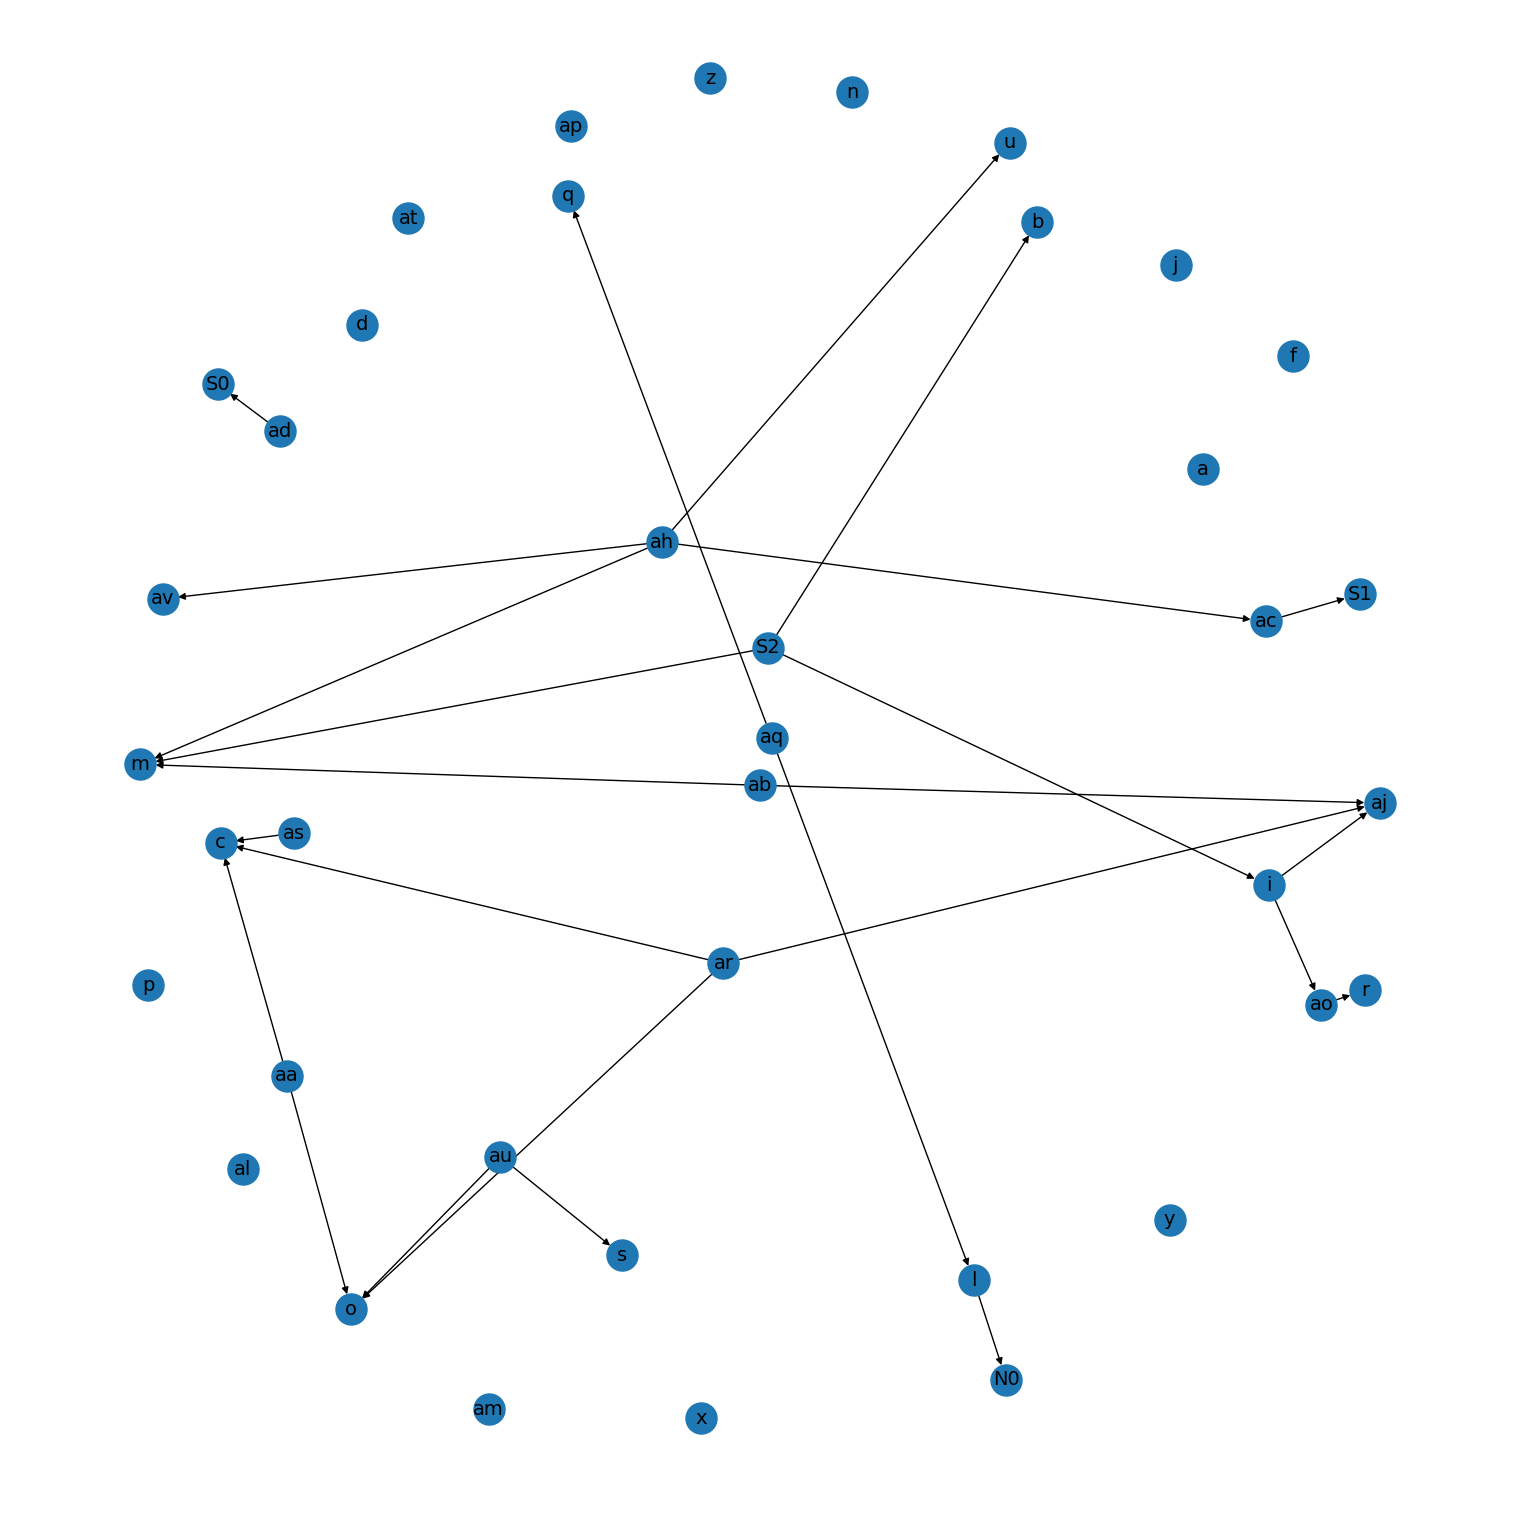

In [234]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
nx.draw(G,with_labels=True,node_size=500,font_size=14)
plt.show()

In [210]:
def common_out_neighbors(g, i, j):
    return set(g.successors(i)).intersection(g.successors(j))

def common_in_neighbors(g, i, j):
    return set(g.predecessors(i)).intersection(g.predecessors(j))

In [ ]:
# G = nx.from_pandas_adjacency(rel_matrices['conditionsFor'],create_using=nx.DiGraph)

In [233]:
# for all relations get pairs of nodes that share at least a common successor or predecessor in this adjencency graph
nestings_per_rel = {}
relations_to_remove = {}
new_events = set()
relations_to_add = {}
i = 0
dcr = deepcopy(dcrs[1])
for rel in ['conditionsFor']:#,'responseTo','excludesTo','includesTo']:
    nestings = {}
    # G = None
    new_nestings_found = True
    print(f'[i] {rel}')
    # if not G:
    G = nx.from_pandas_adjacency(rel_matrices[rel],create_using=nx.DiGraph)
    relations_to_remove[rel] = {}
    relations_to_add[rel] = {}
    while new_nestings_found:
        new_arrows = set()
        new_nodes = set()
        arrows_to_remove = set()
        largest_nesting = {}
        # sem_for_nestings = semantics_obj.DcrSemantics(dcr)
        for e in dcr['events']:
            largest_nesting[e] = 0
        # they have to be top level events
        for e in G.nodes:
            for e_prime in G.nodes:
                if e!=e_prime:
                    cin = common_in_neighbors(G,e,e_prime)
                    cin.discard(e)
                    cin.discard(e_prime)
                    # cin = cin.intersection(sem_for_nestings.tl_events)
                    con = common_out_neighbors(G,e,e_prime)
                    con.discard(e)
                    con.discard(e_prime)
                    # con = con.intersection(sem_for_nestings.tl_events)
                    if len(cin) > 0 or len(con) > 0:
                        if len(cin)>0:
                            for c in cin:
                                largest_nesting[c] += 1
                        if len(con)>0:
                            for c in con:
                                largest_nesting[c] += 1
                        print(f'{e} and {e_prime} | cin: {cin} con: {con}')
        if max(largest_nesting.values())>0:
            e = max(largest_nesting,key=largest_nesting.get)
            print(f'[i] Largest nesting: {e} {max(largest_nesting.values())}')
            suc_e = set(G.successors(e))
            print(e)
            print(suc_e)
            if len(suc_e)>1:
                nestings[f'N{i}'] = suc_e
                # dcr['events'].add(f'N{i}')
                # dcr['subprocesses'][f'N{i}'] = suc_e
                new_events.add(f'N{i}')
                new_nodes.add(f'N{i}')
                new_arrows.add((e, f'N{i}'))
                i += 1
                for s in suc_e:
                    arrows_to_remove.add((e, s))
            pred_e = set(G.predecessors(e))
            print(pred_e)
            if len(pred_e)>1:
                nestings[f'N{i}'] = pred_e
                # dcr['events'].add(f'N{i}')
                # dcr['subprocesses'][f'N{i}'] = pred_e
                new_events.add(f'N{i}')
                new_nodes.add(f'N{i}')
                new_arrows.add((f'N{i}',e))
                for p in pred_e:
                    arrows_to_remove.add((p, e))
                i += 1

            relations_to_remove[rel].update(arrows_to_remove)
            relations_to_add[rel].update(new_arrows)
            for k,v in arrows_to_remove:
                print(f'here {k}, {v}')
                G.remove_edge(k,v)
            for k in new_nodes:
                G.add_node(k)
            for k,v in new_arrows:
                G.add_edge(k,v)
        else:
            new_nestings_found = False
            print(f'[!] No nestings for rel {rel}')

        new_nestings_found = False

    nestings_per_rel[rel] = nestings
print(nestings_per_rel)

[i] conditionsFor
S2 and ab | cin: set() con: {'m'}
S2 and ah | cin: set() con: {'m'}
S2 and l | cin: set() con: {'m'}
aa and ar | cin: set() con: {'c', 'o'}
aa and as | cin: set() con: {'c'}
aa and au | cin: set() con: {'o'}
ab and S2 | cin: set() con: {'m'}
ab and ah | cin: set() con: {'m'}
ab and ar | cin: set() con: {'aj'}
ab and i | cin: set() con: {'aj'}
ab and l | cin: set() con: {'m'}
ac and av | cin: {'ah'} con: set()
ac and m | cin: {'ah'} con: set()
ac and u | cin: {'ah'} con: set()
ah and S2 | cin: set() con: {'m'}
ah and ab | cin: set() con: {'m'}
ah and l | cin: set() con: {'m', 'u', 'av'}
aj and ao | cin: {'i'} con: set()
aj and c | cin: {'ar'} con: set()
aj and m | cin: {'ab'} con: set()
aj and o | cin: {'ar'} con: set()
ao and aj | cin: {'i'} con: set()
ao and l | cin: set() con: {'r'}
ar and aa | cin: set() con: {'c', 'o'}
ar and ab | cin: set() con: {'aj'}
ar and as | cin: set() con: {'c'}
ar and au | cin: set() con: {'o'}
ar and av | cin: {'l'} con: set()
ar and d |

In [199]:
nesting_dcr = deepcopy(rtfmp_reference_dcr)
nesting_dcr['events'] = nesting_dcr['events'].union(new_events)
nesting_dcr['marking']['included'] = nesting_dcr['marking']['included'].union(new_events)
for rel in ['conditionsFor','responseTo','excludesTo','includesTo']:
    for e,e_prime in relations_to_remove[rel].items():
        nesting_dcr[rel][e].discard(e_prime)
    for e,e_prime in relations_to_add[rel].items():
        if e not in nesting_dcr[rel]:
            nesting_dcr[rel][e] = set([e_prime])
        else:
            nesting_dcr[rel][e].add(e_prime)
    nesting_dcr['subprocesses'].update(nestings_per_rel[rel])
nesting_dcr

{'events': {'Add penalty',
  'Appeal to Judge',
  'Create Fine',
  'Insert Date Appeal to Prefecture',
  'Insert Fine Notification',
  'N0',
  'N1',
  'N2',
  'Notify Result Appeal to Offender',
  'Payment',
  'Receive Result Appeal from Prefecture',
  'Send Appeal to Prefecture',
  'Send Fine',
  'Send for Credit Collection'},
 'conditionsFor': {'Payment': set(),
  'Insert Date Appeal to Prefecture': set(),
  'Appeal to Judge': set(),
  'Receive Result Appeal from Prefecture': set(),
  'Send Appeal to Prefecture': set(),
  'Notify Result Appeal to Offender': set(),
  'Add penalty': set(),
  'Create Fine': set(),
  'Insert Fine Notification': set(),
  'Send Fine': set(),
  'Send for Credit Collection': {'Add penalty'},
  'N0': {'Create Fine'},
  'N1': {'Insert Fine Notification'},
  'N2': {'Send Fine'}},
 'milestonesFor': {'Payment': set(),
  'Insert Date Appeal to Prefecture': set(),
  'Appeal to Judge': set(),
  'Receive Result Appeal from Prefecture': set(),
  'Send Appeal to Prefec